In [1]:
import os
import cv2
import numpy as np

spectrograms = []
labels = []

# dossier = "./dataset/data/ordered_clips/"


# def read_files(folder, folder_name):
#     for file in os.listdir(folder):
#         file_path = os.path.join(folder, file)
#         file_ = cv2.imread(file_path)

#         if(file_ is not None):
#             spectrograms.append(file_)
#             labels.append(folder_name)
        
# for nom_fichier in os.listdir(dossier):
#     chemin_fichier = os.path.join(dossier, nom_fichier)

#     # Vérifier si l'élément est un dossier
#     if os.path.isdir(chemin_fichier):
#         read_files(chemin_fichier, nom_fichier)

# print(spectrograms[0].shape)

In [2]:
import librosa

def extract_features(row):
    clips_path = "./dataset/data/clips/"
    clip_path = clips_path + row.path + ".mp3"
    features = {}
    
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(clip_path) 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    features["mfccs"] = mfccs

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    features["stft"] = stft

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features["chroma"] = chroma

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    features["mel"] = mel

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features["contrast"] = contrast

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    features["tonnetz"] = tonnetz        
    
    if(row.gender == "male"): row.gender = 1
    else: row.gender = 0


    print("mfccs:", mfccs)
    print("stft:", stft)
    print("chroma:", chroma)
    print("mel:", mel)
    print("contrast:", contrast)
    print("tonnetz:", tonnetz)
    
    # * columns: client_id, path, age, gender, mfccs, stft, chroma, mel, contract, tonnetz 
    data = [row.client_id, row.gender, mfccs, stft, chroma, mel, contrast, tonnetz]
    return data

In [3]:
def audio_pipeline(row):  
  clips_path = "./dataset/data/clips/"
  clip_path = clips_path + row.path + ".mp3"
  features = {}

  # Loads the audio file as a floating point time series and assigns the default sample rate
  # Sample rate is set to 22050 by default
  audio, sample_rate = librosa.load(clip_path) 

  if(row.gender == "male"): row.gender = 1
  else: row.gender = 0

  features = []

  features.append(row["client_id"])
  features.append(row["gender"])
  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCCs
  mfccs = librosa.feature.mfcc(y=audio)
  # print("mfccs len:", len(mfccs))

  for x in mfccs:
    features.append(np.mean(x))



  return features

# Read dataset


## rename client id

In [4]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = pd.read_table("./dataset/train.tsv")
dataframe = dataframe.drop(columns=["up_votes", "accent", "sentence", "down_votes"])

client_ids = dataframe.groupby(["client_id"]).sum().reset_index()["client_id"].tolist()
new_client_id = [x for x in range(len(client_ids) + 1)]

def rename_client(row):
    return client_ids.index(row["client_id"])

# * Rename client_id
dataframe["client_id"] = dataframe.apply(rename_client, axis=1)

print(dataframe["client_id"])

0        48
1        48
2        48
3        48
4        48
         ..
18933    58
18934    58
18935    58
18936    58
18937    58
Name: client_id, Length: 18938, dtype: int64


# Data filtering

<Axes: xlabel='client_id', ylabel='count'>

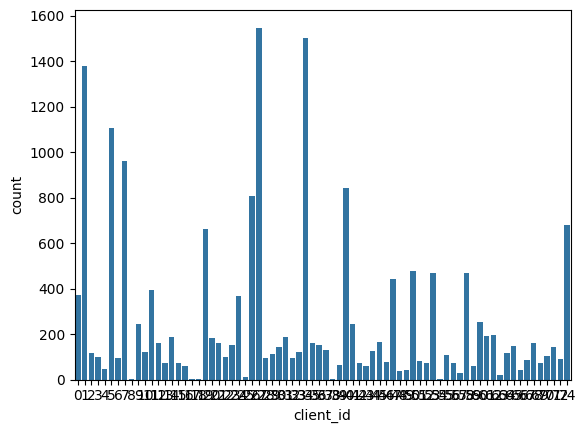

In [39]:
sns.countplot(x=dataframe["client_id"]) # plot the categories

In [41]:
print(dataframe.query("client_id == 1"))

       client_id                                               path       age  \
17090          1  1f0193f454471d950810b7935d712b45ae4f5ddad735a8...  fourties   
17091          1  b206709c8b8bf975dfa01ed9fadf578418a9a5670a9a77...  fourties   
17092          1  8eab9439c5fed9fe692ebfad57974203d1ae2f9aeffdab...  fourties   
17093          1  c37120ccb46cf34bb65c478ed75466b6bbf5024873a132...  fourties   
17094          1  ea4cff95f58cf1d3037149cf0b3eb461dbcc8851039a7e...  fourties   
...          ...                                                ...       ...   
18464          1  a3187b8640ea617e2b7d5b73cf548a196c25183fa9f566...  fourties   
18465          1  da4fc0af2b29907260ead4e91606f2d7f8e86fd5a0cfff...  fourties   
18466          1  34d7cd8fb083264ce26b480ed5aa47577b36110ac79734...  fourties   
18467          1  6cf7083b3f4789ab84adb235dfa76e769f6c43b275b790...  fourties   
18468          1  8085522178082afb5aa2b17a2d41da94406a2c3b885450...  fourties   

      gender  
17090   male

In [50]:
print(len(dataframe))

filtered = pd.DataFrame(columns=dataframe.columns)

occurances = dataframe.groupby("client_id").size()
print(occurances)

for occurance in occurances.items():
    # print("occurence", occurance)
    # ! filtre par occurances
    if(occurance[1] < 10):
        id = occurance[0]
        filtered = pd.concat([filtered, dataframe.query("client_id == @id")], ignore_index=True) 

print(filtered.groupby("client_id").size())

18507
client_id
0      372
1     1379
2      118
3       98
4       45
      ... 
69      72
70     105
71     145
72      90
74     678
Length: 74, dtype: int64
client_id
8     4
17    2
18    4
38    3
54    2
dtype: int64


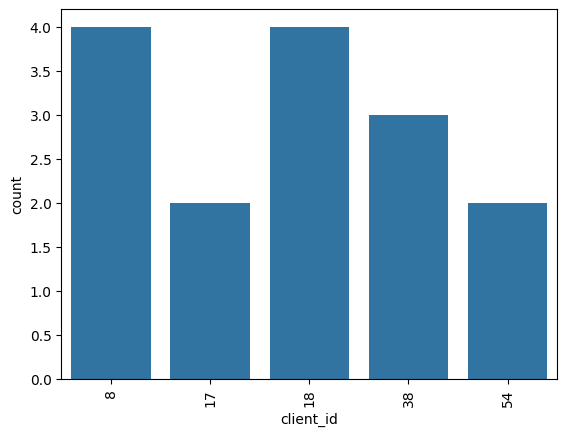

In [48]:
sns.countplot(x=filtered["client_id"]) # plot the categories
plt.xticks(rotation=90);

# Extract audio feature


## Custom code

In [168]:

# * extrait des segment de 1 seconde de l'audio et les retourne
def extract_segments(audio, sr):
    # Définir la durée de chaque segment en secondes
    segment_duration = 2

    # Convertir la durée du segment en nombre d'échantillons
    segment_length = int(segment_duration * sr)

    # Découper l'audio en segments de 1 seconde
    segments = [audio[i : i + segment_length] for i in range(0, len(audio), segment_length)]
    return segments

# * segmentes un audio et pour chaque segment extrait des features
def segment_audio_features(row):
    clips_path = "./dataset/data/clips/"
    audio_file = clips_path + row.path + ".mp3"
    audio, sr = librosa.load(audio_file)

    # Découper l'azaudio en segments de 1 seconde
    segments = extract_segments(audio, sr)
    # print("SEGMENTS:", row["client_id"], segments)
    
    # Extraction des caractéristiques pour chaque segment
    features = []
    for segment in segments:
        segment_features = extract_feature_from_segment(segment, row["client_id"])
        features.append(segment_features)

    return segments, features

# * extrait des features d'un segment d'audio
def extract_feature_from_segment(segment, client_id):
    features = []

    features.append(client_id)

    chroma_stft = librosa.feature.chroma_stft(y=segment)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    rms = librosa.feature.rms(y=segment)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Calcul de la moyenne du Spectral centroid

    # spectral_centroids = librosa.feature.spectral_centroid(y=segment)[0]
    spectral_centroids = librosa.feature.spectral_centroid(y=segment)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    rolloff = librosa.feature.spectral_rolloff(y=segment)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    zcr = librosa.feature.zero_crossing_rate(y=segment)
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    harmony = librosa.effects.harmonic(y=segment)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    tempo = librosa.feature.tempo(y=segment)
    features.append(tempo[0])

    # Calcul des moyennes des MFCC

    mfcc = librosa.feature.mfcc(y=segment)

    # print(len(mfcc))
    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))
    # print("ftlen:", len(features))
    return features


In [169]:
# columns = ["client", "gender", "mfccs", "stft", "chroma", "mel", "contrast", "tonnetz"]
columns_audio_pipeline = [
    "client",
    # "gender",
    # "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8", "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16", "mfcc17", "mfcc18", "mfcc19", "mfcc20",

    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
    
    "chroma_stft_mean",
    "chroma_stft_var",
    
    "rms_mean", 
    "rms_var",

    "spectral_centroids_mean",
    "spectral_centroids_var",

    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    
    "rolloff_mean", 
    "rolloff_var", 
    
    "zcr_mean", 
    "zcr_var", 

    "harmony_mean",
    "harmony_var",

    "tempo",
    # 'zcr', 'spectral_c', 'rolloff'
]
features_df = pd.DataFrame(columns=columns_audio_pipeline)

# print(len(filtered))
# print(filtered)
index = 0
for i in range(len(filtered)):
    segments, features = segment_audio_features(filtered.loc[i])
    for feature in features:
        features_df.loc[index] = feature
        index += 1
features_df

/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=530
  warnings.warn(
/home/lucas/PersonalDEV/voice-recognizer/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


,client,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,...,spectral_centroids_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zcr_mean,zcr_var,harmony_mean,harmony_var,tempo
0,8.0,0.411729,0.094910,0.064565,3.299642e-03,1567.649710,7.735075e+05,1892.059728,567504.853745,3250.028623,...,3.529346,49.884338,0.808817,60.711414,-0.859311,51.144447,-1.032310,27.944550,-0.908253,44.946117
1,8.0,0.489529,0.083692,0.000805,3.122790e-08,2076.854606,9.386636e+04,2689.613134,62147.551475,5097.007058,...,6.646700,20.919336,4.281754,22.554476,4.344616,30.334978,-2.642743,24.830452,6.446429,15.907321
2,8.0,0.391586,0.098732,0.084355,6.473543e-03,1934.860685,1.056212e+06,2184.834476,413641.391180,4106.282833,...,-1.501245,74.507477,1.425582,44.753746,0.610056,48.433514,-0.898599,40.608059,0.957220,39.467167
3,8.0,0.360158,0.097549,0.077079,1.322316e-03,1544.300396,7.647177e+05,1851.756143,255392.329032,3266.982927,...,-4.897107,108.660187,0.460021,109.832573,-0.941581,31.388803,-5.342826,132.581375,-5.267600,57.457088
4,8.0,0.412253,0.092171,0.074543,5.851355e-03,1657.110270,6.150539e+05,1934.601159,443191.416853,3354.600788,...,1.743671,94.152489,0.616867,104.136215,0.399774,53.173973,2.101759,69.463463,0.922495,42.040192
5,8.0,0.634828,0.041112,0.000229,0.000000e+00,2039.528919,1.410434e+03,2449.970382,160.598548,4425.073242,...,-2.169284,0.007914,-1.390587,0.180717,8.332781,9.432324,6.910899,4.405143,1.812554,1.264377
6,8.0,0.395954,0.096728,0.076451,5.427009e-03,1752.308198,7.038715e+05,2071.975024,556468.565877,3701.235857,...,1.803756,54.715317,-1.073021,37.775906,-2.493613,60.936226,-0.185483,32.128998,-0.931047,60.550873
7,8.0,0.367352,0.090324,0.056709,1.295259e-03,1601.612894,5.846330e+05,1806.631893,289022.178321,3041.874327,...,-0.582941,69.293327,0.264618,57.719322,-3.044349,70.594254,-1.164287,53.996204,-1.467119,45.820065
8,8.0,0.487433,0.087473,0.000279,1.249753e-09,2090.622763,1.402915e+04,2713.998143,7015.371584,5252.666016,...,5.023406,31.816219,3.392893,14.435769,3.967775,7.345579,-1.821997,14.602457,2.423588,13.651359
9,8.0,0.374505,0.103053,0.088217,8.969816e-03,1789.933952,6.068080e+05,2029.447153,342635.877016,3717.818898,...,0.810950,32.867611,-3.328211,63.523487,-2.645967,72.908653,1.579970,23.962070,-0.205037,44.272110


In [170]:
labels = features_df['client']
features = features_df.drop('client', axis = 1)
print("feature to frame:", labels.to_frame())
labels.shape

feature to frame:     client
0      8.0
1      8.0
2      8.0
3      8.0
4      8.0
5      8.0
6      8.0
7      8.0
8      8.0
9      8.0
10     8.0
11     8.0
12     8.0
13    17.0
14    17.0
15    17.0
16    17.0
17    17.0
18    18.0
19    18.0
20    18.0
21    18.0
22    18.0
23    18.0
24    18.0
25    18.0
26    18.0
27    18.0
28    18.0
29    38.0
30    38.0
31    38.0
32    38.0
33    38.0
34    38.0
35    38.0
36    38.0
37    38.0
38    38.0
39    38.0
40    38.0
41    38.0
42    54.0
43    54.0
44    54.0
45    54.0


(46,)

In [195]:
# split data to train and test data
from sklearn.model_selection import train_test_split

labels_ = [x for x in set(labels)]
print("labels", labels_)
x = np.array(features, dtype = float)
y = np.array(labels)

print(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


labels [38.0, 8.0, 17.0, 18.0, 54.0]
[ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8. 17. 17. 17. 17. 17.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 38. 38. 38. 38. 38. 38. 38.
 38. 38. 38. 38. 38. 38. 54. 54. 54. 54.]


((30, 55), (16, 55), (30,), (16,))

In [197]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoder()
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
y_train = encoder.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = encoder.fit_transform(y_test)

# print(x_train[0])
x.shape, y.shape

[-0.28657882  0.96032653  0.37560459  1.10938252  1.23712923  1.3508549
  0.44527384  1.74883399  0.71503029  1.23389823  1.16156001  0.87858216
  1.31565009  0.3917977   2.40227818  0.23036401  0.86251699 -0.92130375
 -0.13049393 -0.68902906 -0.76936414  0.40918023  1.80264894  1.25325099
  0.29699723  0.95598714 -0.92924659  0.92476061  0.45334674 -0.5919194
  0.54790037 -1.45490194  2.20568297 -0.80765855 -0.15092445  1.09646141
 -1.11365173 -0.62938442  1.29535074 -0.1624301   0.65312986  0.04413525
 -0.4352782  -0.8113298  -0.25306524  0.66767528  1.71743259 -0.96876227
  1.31841378 -1.31420221  0.65697373  0.71122023 -0.75807249 -0.75315073
  0.38189135]


((46, 55), (46,))

# Model function


In [173]:
from keras.models import Sequential
from keras.layers import Dense

def create_model():
    # création du modèle
    model = Sequential()
    model.add(Dense(25, input_shape=(55,), activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [174]:
print(len(new_client_id))

79


In [175]:
from tensorflow import keras
from keras.optimizers import Adam

# build model
model = keras.models.Sequential([
    keras.layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(27, activation = 'softmax'),
    
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                3584      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 27)                891       
                                                                 
Total params: 6555 (25.61 KB)
Trainable params: 6555 (25.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [176]:
y_test.shape = (y_test.shape[0], 1)
y_train.shape = (y_train.shape[0], 1)

print(y_train.shape)
print(y_test.shape)

print(x_train.shape, x_test.shape)
y_train

(30, 1)
(16, 1)
(30, 55) (16, 55)


array([[2],
       [1],
       [2],
       [3],
       [0],
       [2],
       [4],
       [0],
       [3],
       [0],
       [0],
       [1],
       [3],
       [2],
       [4],
       [3],
       [3],
       [3],
       [3],
       [1],
       [0],
       [3],
       [3],
       [0],
       [0],
       [0],
       [2],
       [0],
       [3],
       [0]])

In [160]:

# compile model  
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics='accuracy')
# fit le modèles
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
1/1 [==============================] - 0s 453ms/step - loss: 3.2794 - accuracy: 0.0741 - val_loss: 3.2929 - val_accuracy: 0.3214
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 3.2929 - accuracy: 0.2593 - val_loss: 3.2899 - val_accuracy: 0.3214
Epoch 3/10
1/1 [==============================] - 0s 23ms/step - loss: 3.2900 - accuracy: 0.2593 - val_loss: 3.2869 - val_accuracy: 0.3214
Epoch 4/10
1/1 [==============================] - 0s 23ms/step - loss: 3.2871 - accuracy: 0.2593 - val_loss: 3.2838 - val_accuracy: 0.3214
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 3.2841 - accuracy: 0.2593 - val_loss: 3.2806 - val_accuracy: 0.3214
Epoch 6/10
1/1 [==============================] - 0s 27ms/step - loss: 3.2811 - accuracy: 0.2593 - val_loss: 3.2775 - val_accuracy: 0.3214
Epoch 7/10
1/1 [==============================] - 0s 29ms/step - loss: 3.2780 - accuracy: 0.2593 - val_loss: 3.2743 - val_accuracy: 0.3214
Epoch 8/10
1/1 [==========

In [161]:
_, accuracy = model.evaluate(x_test, y_test, batch_size=128)

1/1 [==============================] - 0s 20ms/step - loss: 3.2647 - accuracy: 0.3214


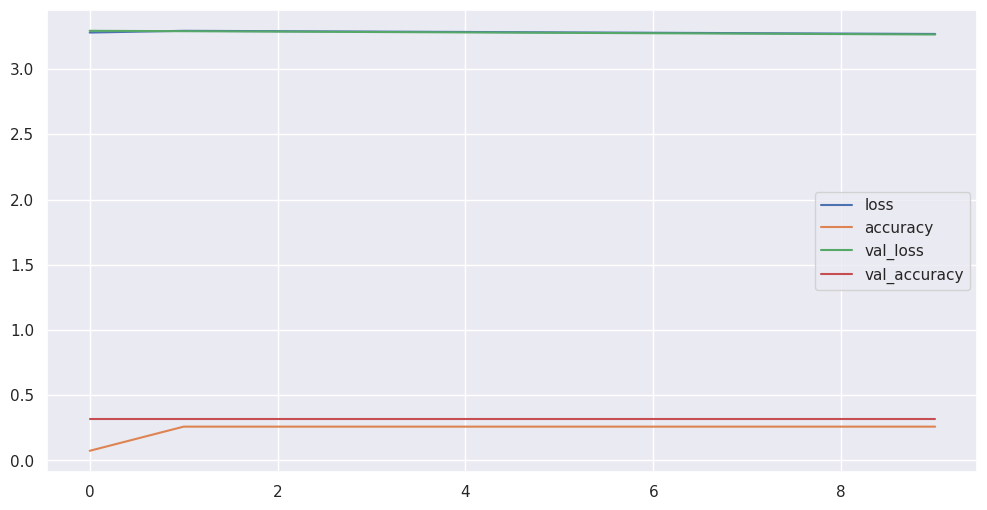

In [162]:
import matplotlib.pyplot as plt
# Plot results
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()


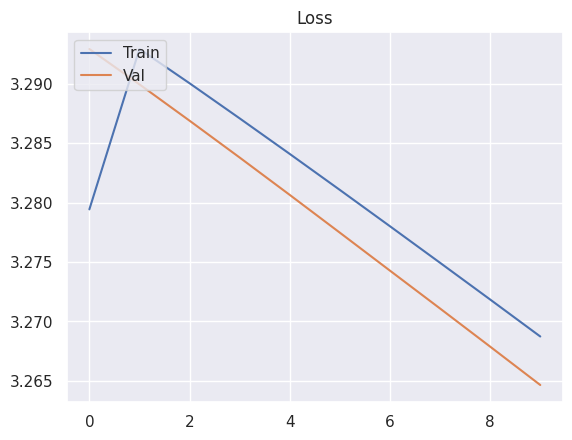

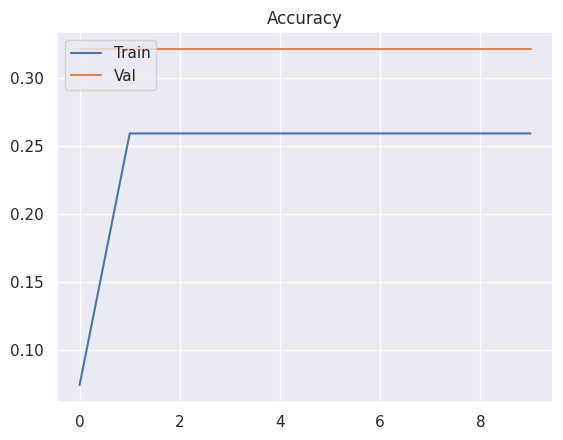

In [163]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [164]:
labels = np.array(labels[:])
print("labels:", labels, len(labels))

print("features:")
print(x_test)

labels: [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8. 17. 17. 17. 17. 17. 17. 17. 17. 17. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 38. 38. 38.
 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38. 38.
 38. 38. 54. 54. 54. 54. 54. 54. 54. 54.] 82
features:
[[ 0.00800627  0.85406388  0.75379386 ...  1.5953592  -0.64411089
   2.05649143]
 [ 1.73780821 -0.70845529 -1.39273906 ... -1.7896614   1.99831769
  -0.81774491]
 [ 0.73633814 -0.07219666 -0.08039552 ... -1.07384561  0.16568354
   0.06176059]
 ...
 [-0.06609033  0.54376761 -0.72853995 ... -0.17616992  0.10587347
  -0.63969149]
 [-0.81490091  0.68758625 -0.10962715 ...  0.2086672  -0.40586868
   0.02359841]
 [ 0.50984264 -0.5548428  -1.03162994 ...  0.67375822  1.23925622
  -0.32181072]]


In [165]:

print(len(new_client_id))
print(len(x_train))
print(len(x_test))

79
54
28


In [190]:
from sklearn.metrics import confusion_matrix 

sns.set()
predictions = model.predict(x_test)

genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
probs = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)

predicted_classes = np.argmax(probs, axis=1)
predicted_class_names = [genres[class_index] for class_index in predicted_classes]


for i in range(len(predicted_class_names)):
    print(f"Prédiction pour la musique {i + 1}: {predicted_class_names[i]}")



1/1 [==============================] - 0s 17ms/step
Prédiction pour la musique 1: 26
Prédiction pour la musique 2: 19
Prédiction pour la musique 3: 26
Prédiction pour la musique 4: 26
Prédiction pour la musique 5: 19
Prédiction pour la musique 6: 19
Prédiction pour la musique 7: 19
Prédiction pour la musique 8: 19
Prédiction pour la musique 9: 19
Prédiction pour la musique 10: 26
Prédiction pour la musique 11: 19
Prédiction pour la musique 12: 26
Prédiction pour la musique 13: 19
Prédiction pour la musique 14: 26
Prédiction pour la musique 15: 19
Prédiction pour la musique 16: 19


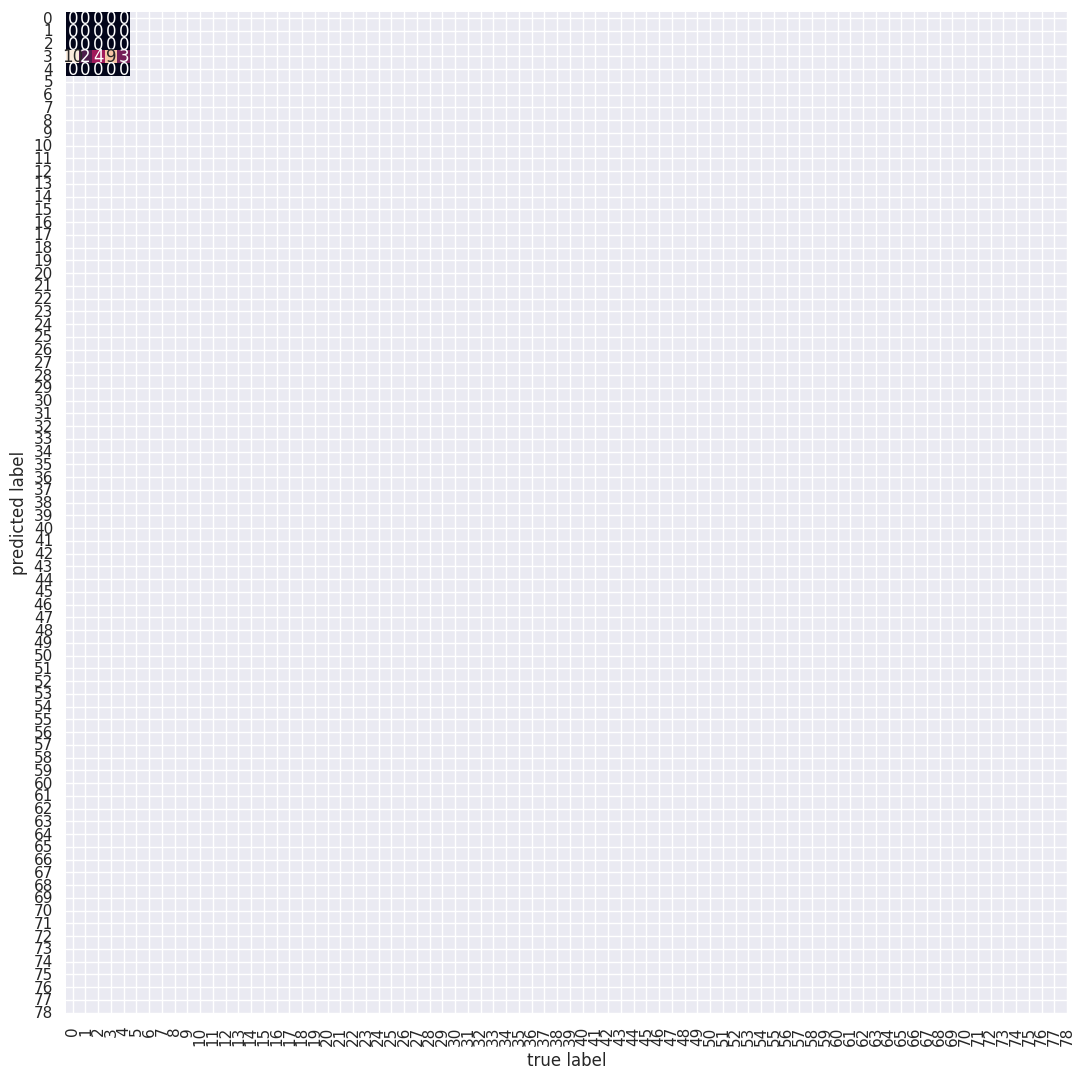

In [167]:
mat = confusion_matrix(y_test, np.argmax(predictions, 1))
plt.figure(figsize=(15, 13))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=new_client_id, yticklabels=new_client_id)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [238]:
print(predictions[1], len(predictions[1]))
print(len(y_test))

[4.2633479e-03 1.5289540e-04 2.1349671e-01 2.8632590e-04 5.4368237e-03
 9.6907787e-02 6.2911421e-02 6.0279286e-03 6.2757789e-04 2.0845300e-02
 3.4666839e-03 1.5285307e-03 1.1416325e-04 2.2834553e-03 2.1762408e-03
 8.0758001e-04 1.1253268e-03 6.8617746e-02 3.6067858e-01 8.6186896e-04
 1.7995496e-04 2.8530896e-02 2.9765815e-03 1.5202601e-04 1.0276118e-01
 2.8722968e-03 9.9107390e-03] 27
700
